# Project 2——Fine tune llms
<center>name:文浩宇</center>
<center>id:1120213407</center>
<center>class:07022101</center>

**note:**由于放假离校，所以无法使用内网服务器，于是在colab上尝试完成此次实践（微调llama2-7B）。


*挂载google drive(提前上传了数据集以及llama2-7b的权重)*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


*当前路径以及数据、模型路径*

In [2]:
data_root = "/content/drive/MyDrive/datas/reclor_data"
model_path = "/content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf"
!pwd
!ls $data_root
!ls $model_path

/content
process  question_type_names.json  source_list.txt  test.json  train.json  use_items.txt  val.json
config.json			  pytorch_model-00002-of-00002.bin  tokenizer_config.json
generation_config.json		  pytorch_model.bin.index.json	    tokenizer.json
pytorch_model-00001-of-00002.bin  special_tokens_map.json	    tokenizer.model


***Data pre-process***
将原来的数据格式转化为微调数据的格式（暂时未加入CoT）。
```json
[
{instruct:"",
input:"",
output:"",}
]
```


In [3]:
import os
import json
import random
random.seed(42)

In [4]:

def data_pre_process(path, tgt_root, tgt_name, test=False):
  """
  将原本的数据格式转化为微调可用格式。
  这里处理的不是很好，将所有东西都揉在了'instruct'里面，在后续加载数据集的时候
  又添加了额外的prompt进去...
  """
  #to do, try...except..., though not necessary
  with open(path, 'r') as f:
    datas = json.load(f)
  print(f"{path} length: {len(datas)}")
  results = []
  for data in datas:
    answers = ""
    for i in range(len(data['answers'])):
      answers += f"{i}:{data['answers'][i]}\n"
    results.append({"instruct":"context:\n"+data['context']+"\n\n"+"question:\n"+data['question']+"\n\n"+"choices:\n"+answers+"\n\n","input":"","output":f"{data['label']}" if not test else ""})
  # print(results[0])
  if not os.path.exists(tgt_root):
    os.mkdir(tgt_root)
  with open(os.path.join(tgt_root,tgt_name), 'w', encoding='utf-8') as f:
    json.dump(results, f)

def get_data_instance(path):
  """
  返回打开的文件的内容（数据集内容）
  ps:没有异常处理，使用时注意
  """
  with open(path, 'r') as f:
    datas = json.load(f)
  return datas

def formatting_func_train(prompt):
  text = f"### According to given context, question and choices, choose \
  the correct answer: \n{prompt['instruct']}\n ### Output:{prompt['output']}\n<\s>"
  return text

def formatting_func_test(prompt):
  text = f"### According to given context, question and choices, choose \
  the correct answer: \n{prompt['instruct']}\n ### Output:{prompt['output']}\n"
  return text

In [5]:
data_pre_process(os.path.join(data_root, "train.json"), os.path.join(data_root, "process"), "train.json")
data_pre_process(os.path.join(data_root, "val.json"), os.path.join(data_root, "process"), "val.json")
data_pre_process(os.path.join(data_root, "test.json"), os.path.join(data_root, "process"), "test.json", test=True)
train_data_path = os.path.join(data_root, "process","train.json")
val_data_path = os.path.join(data_root, "process","val.json")
test_data_path = os.path.join(data_root, "process","test.json")

/content/drive/MyDrive/datas/reclor_data/train.json length: 4638
/content/drive/MyDrive/datas/reclor_data/val.json length: 500
/content/drive/MyDrive/datas/reclor_data/test.json length: 1000


**Before finetune， Chat with base model**

Sample了两个test数据，并且编造了两个测试in-context learing的数据

In [6]:
!pip install transformers peft accelerate bitsandbytes datasets

In [7]:
from transformers import LlamaForCausalLM, AutoTokenizer
import torch
def inference(prompt, model, tokenizer):
  inputs = tokenizer(prompt, return_tensors="pt")
  inputs.input_ids=inputs.input_ids.to('cuda')

  # Generate
  generate_ids = model.generate(inputs.input_ids, max_new_tokens=1024)
  res = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  return res



**load model and tokenizer**

In [8]:
#下载好的hf模型地址
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LlamaForCausalLM.from_pretrained(model_path, device_map="auto")
# model.to(device)
# model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_path)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [9]:
test_data1, test_data2 = random.sample(get_data_instance(test_data_path), 2)
incontext_data_1 = """
  Circulation revenue has increased by 5% in Finland. // Positive\n
  Panostaja did not disclose the purchase price. // Neatral\n
  Paying off the national debt will be extremely painful. // Negative\n
  The company anticipated its operating profit to improve. // """
incontext_data_2 = """
  Circulation revenue has increased by 5% in Finland. // Finance\n
  They defeated ... in the NFC Championship Game. // Sports\n
  Apple ... development of in-house chips. // Tech\n
  The company anticipated its operating profit to improve. //"""
print("######")
print(formatting_func_test(test_data1))
print("######")
print(formatting_func_test(test_data2))
print("######")
print(incontext_data_1)
print("######")
print(incontext_data_2)
print("######")


######
### According to given context, question and choices, choose   the correct answer: 
context:
Council member: I recommend that the abandoned shoe factory be used as a municipal emergency shelter. Some council members assert that the courthouse would be a better shelter site, but they have provided no evidence of this. Thus, the shoe factory would be a better shelter site.

question:
A questionable technique used in the council member's argument is that of

choices:
0:accepting a claim simply because advocates of an opposing claim have not adequately defended their view
1:attacking the proponents of the courthouse rather than addressing their argument
2:attacking an argument that is not held by any actual council member
3:asserting that a lack of evidence against a view is proof that the view is correct



 ### Output:

######
### According to given context, question and choices, choose   the correct answer: 
context:
An advertisement states: Like Danaxil, all headache pills can s

In [10]:
res1 = inference(formatting_func_test(test_data1), model, tokenizer)
res2 = inference(formatting_func_test(test_data2), model, tokenizer)
res3 = inference(incontext_data_1, model, tokenizer)
res4 = inference(incontext_data_2, model, tokenizer)
print("Base_model:")
print("&&&&&&&&&&&&&&&&&&")
print(res1)
print("&&&&&&&&&&&&&&&&&&")
print(res2)
print("&&&&&&&&&&&&&&&&&&")
print(res3)
print("&&&&&&&&&&&&&&&&&&")
print(res4)


Base_model:
&&&&&&&&&&&&&&&&&&
### According to given context, question and choices, choose   the correct answer: 
context:
Council member: I recommend that the abandoned shoe factory be used as a municipal emergency shelter. Some council members assert that the courthouse would be a better shelter site, but they have provided no evidence of this. Thus, the shoe factory would be a better shelter site.

question:
A questionable technique used in the council member's argument is that of

choices:
0:accepting a claim simply because advocates of an opposing claim have not adequately defended their view
1:attacking the proponents of the courthouse rather than addressing their argument
2:attacking an argument that is not held by any actual council member
3:asserting that a lack of evidence against a view is proof that the view is correct



 ### Output:














































































































































可以看到，basemodel对于test的数据回答，不准确。

base model 第一个问题没有回答（在某些测试情况下会回答...可能需要控制温度、top_k参数等）
对于第二个回答内容也不正确，它重复了0，1，2，3...
而对于in-context learing，则似乎有相应能力，可能因为token设置不当导致重复（且重复内容有时候会“突变”）。

**Start Fine Tune！**
>references(部分):
>- [Parameter-Efficient Fine-Tuning using 🤗 PEFT (huggingface.co)](https://huggingface.co/blog/peft)
- [llama-recipes/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb at main · meta-llama/llama-recipes (github.com)](https://github.com/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb)
- [Fine-Tuning LLaMA 2: A Step-by-Step Guide to Customizing the Large Language Model | DataCamp](https://www.datacamp.com/tutorial/fine-tuning-llama-2)
- [使用單一 GPU 微調 LLaMA2 - Tech Learning (erhwenkuo.github.io)](https://erhwenkuo.github.io/huggingface/tutorials/llama2/fine-tuning-llama-2-models-using-a-single-gpu/)
- [https://huggingface.co/docs/peft/en/developer_guides/quantization](https://huggingface.co/docs/peft/en/developer_guides/quantization)
- [Llama2+LoRA指令微调实战记录](https://zhuanlan.zhihu.com/p/659154202)

**prepare datas**

In [63]:
# prepare data
from datasets import load_dataset
train_dataset = load_dataset('json', data_files=train_data_path, split='train')
eval_dataset = load_dataset('json', data_files=val_data_path, split='train')


**load model 且设置量化参数**

In [64]:
# load base model
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer

base_model_id = model_path
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**load tokenizer**

In [65]:
# tokenization
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func_train(prompt))

In [66]:
# print(type(train_dataset[0]))
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

**查看数据的长度情况**

5138


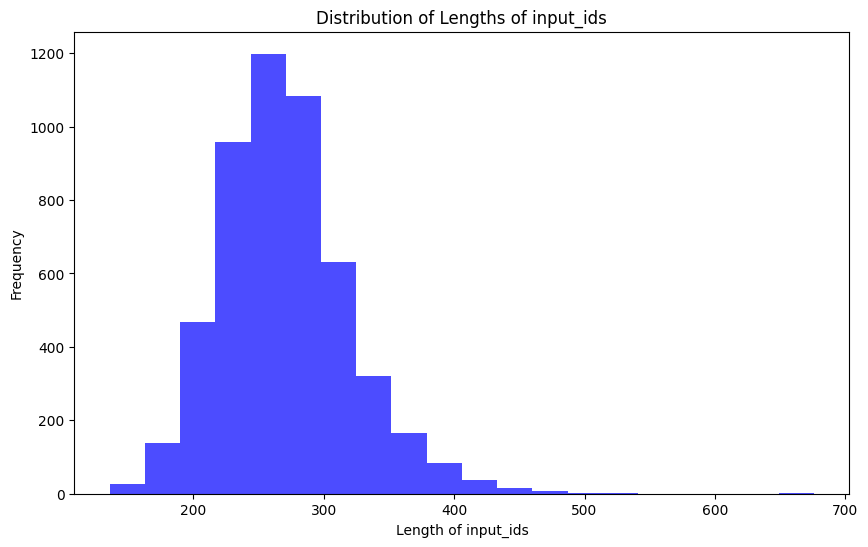

In [67]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [73]:
max_length = 1536 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt, max_length=max_length):
    result = tokenizer(
        formatting_func_train(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [61]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/4638 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

**配置lora参数**

In [62]:
# PEFT
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "v_proj",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)


In [30]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.7 MB/s eta 0:00:00


**配置其他参数**

In [53]:
import transformers
from datetime import datetime
import wandb
wandb.login()
special_words = "withoutCoT"
project = "llama2-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project + '-' + special_words
output_dir = "/content/drive/MyDrive/finetune/" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        num_train_epochs=3,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="/content/drive/MyDrive/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        logging_steps=50, # new append
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,1.304700,1.328504
100,1.331300,1.318070
150,1.313500,1.310868
200,1.304800,1.305644
250,1.283700,1.301206
300,1.310100,1.297979
350,1.278300,1.294368
400,1.277900,1.292462
450,1.332500,1.291073
500,1.286600,1.290389


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/che

TrainOutput(global_step=500, training_loss=1.302341163635254, metrics={'train_runtime': 1592.5192, 'train_samples_per_second': 0.628, 'train_steps_per_second': 0.314, 'total_flos': 6.1047897587712e+16, 'train_loss': 1.302341163635254, 'epoch': 0.21561017680034497})

**Save model**

In [54]:
# save model
base_model_path = model_path
finetune_model_path = "./finetune/withoutCoT"
merge_model_path = "./merge/withoutCoT"
model.save_pretrained(finetune_model_path) # google drive space not enough ...


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(


In [13]:
from transformers import LlamaTokenizer
from peft import PeftModel

**测试不带CoT微调后的模型**

In [14]:
finetune_model_path = "./finetune/withoutCoT"
merge_model_path = "./merge/withoutCoT"
tokenizer = LlamaTokenizer.from_pretrained(base_model_path)
# first base model, then finetune model
model = LlamaForCausalLM.from_pretrained(base_model_path, load_in_8bit=False, device_map='auto', torch_dtype=torch.float16)
model = PeftModel.from_pretrained(model, finetune_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [15]:
res1_ft1 = inference(formatting_func_test(test_data1), model, tokenizer)
res2_ft1 = inference(formatting_func_test(test_data2), model, tokenizer)
res3_ft1 = inference(incontext_data_1, model, tokenizer)
res4_ft1 = inference(incontext_data_2, model, tokenizer)
print("FT model without CoT")
print("^^^^^^^^^^^~~~~~~~~~")
print(res1_ft1)
print("^^^^^^^^^^^~~~~~~~~~")
print(res2_ft1)
print("^^^^^^^^^^^~~~~~~~~~")
print(res3_ft1)
print("^^^^^^^^^^^~~~~~~~~~")
print(res4_ft1)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


FT model without CoT
^^^^^^^^^^^~~~~~~~~~
### According to given context, question and choices, choose   the correct answer: 
context:
Council member: I recommend that the abandoned shoe factory be used as a municipal emergency shelter. Some council members assert that the courthouse would be a better shelter site, but they have provided no evidence of this. Thus, the shoe factory would be a better shelter site.

question:
A questionable technique used in the council member's argument is that of

choices:
0:accepting a claim simply because advocates of an opposing claim have not adequately defended their view
1:attacking the proponents of the courthouse rather than addressing their argument
2:attacking an argument that is not held by any actual council member
3:asserting that a lack of evidence against a view is proof that the view is correct



 ### Output:
0

 ### Explanation:
The council member's argument is that the shoe factory would be a better shelter site than the courthouse. T

对于**不使用CoTton数据微调**后的model，其对于test数据集sample出来的数据确实回答上有所提升，且model自己加了一项`explanation`。所谓有所提升，首先在于model回答了output字段，其次对于`test_data_1`回答正确，并且`explanation`感觉有CoT的意味了。而对于`test_data_2`回答格式上就不正确。此外其`explanation`也不断重复...

对于in-context learing，它回答的第一句是对的，之后进行重复后，重复内容不稳定、发生改变...

**Finetune with CoT**

重复上述代码，只不过更改了数据集。

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

5138


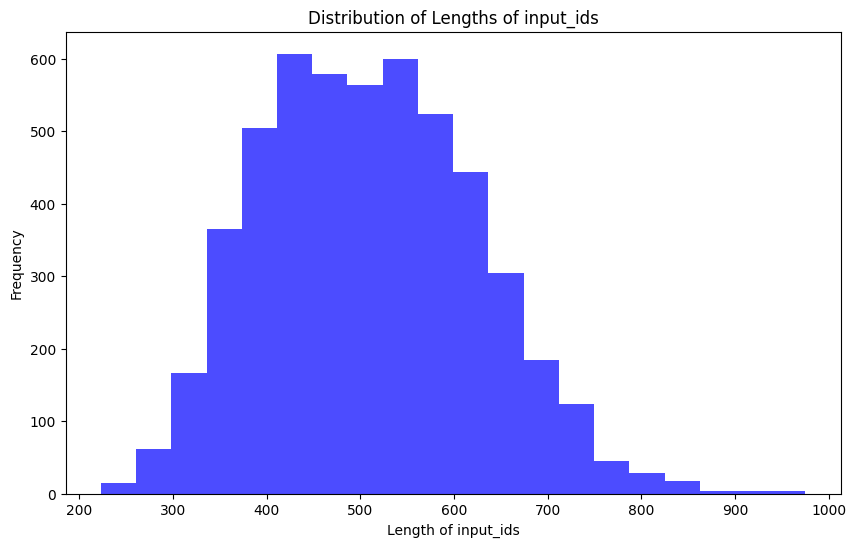

In [78]:
# CoT finetune, 重复之前finetune过程，这里直接写一起了
train_data_path_CoT = "/content/drive/MyDrive/datas/CoT/train.json"
val_data_path_CoT = "/content/drive/MyDrive/datas/CoT/val.json"
train_dataset = load_dataset('json', data_files=train_data_path_CoT, split='train')
eval_dataset = load_dataset('json', data_files=val_data_path_CoT, split='train')

base_model_id = model_path
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [79]:
max_length_CoT= 1536

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "v_proj",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

wandb.login()
special_words = "withCoT"
project = "llama2-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project + '-' + special_words
output_dir = "/content/drive/MyDrive/finetune/" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        num_train_epochs=3,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="/content/drive/MyDrive/logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        logging_steps=50, # new append
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/4638 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,1.315600,1.107478
100,1.058100,1.019898
150,1.004300,0.977524
200,0.965700,0.968004
250,0.953200,0.960850
300,0.968800,0.956478
350,0.949400,0.952343
400,0.950200,0.949550
450,0.977300,0.947943
500,0.947800,0.947398


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/che

TrainOutput(global_step=500, training_loss=1.009040428161621, metrics={'train_runtime': 1593.5867, 'train_samples_per_second': 0.628, 'train_steps_per_second': 0.314, 'total_flos': 6.1047897587712e+16, 'train_loss': 1.009040428161621, 'epoch': 0.21561017680034497})

In [80]:
# save model
base_model_path = model_path
finetune_model_path = "./finetune/withCoT"
merge_model_path = "./merge/withCoT"
model.save_pretrained(finetune_model_path) # google drive space not enough ...




/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /content/drive/MyDrive/models/llama/llama2/Llama2-7b-hf - will assume that the vocabulary was not modified.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [16]:

base_model_path = model_path
finetune_model_path = "./finetune/withCoT"
merge_model_path = "./merge/withCoT"
tokenizer = LlamaTokenizer.from_pretrained(base_model_path)
# first base model, then finetune model
model = LlamaForCausalLM.from_pretrained(base_model_path, load_in_8bit=False, device_map='auto', torch_dtype=torch.float16)
model = PeftModel.from_pretrained(model, finetune_model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [17]:
res1_ft2 = inference(formatting_func_test(test_data1), model, tokenizer)
res2_ft2 = inference(formatting_func_test(test_data2), model, tokenizer)
res3_ft2 = inference(incontext_data_1, model, tokenizer)
res4_ft2 = inference(incontext_data_2, model, tokenizer)
print("FT model with CoT")
print("^^^^^^^^^^^~~~~~~~~~")
print(res1_ft2)
print("^^^^^^^^^^^~~~~~~~~~")
print(res2_ft2)
print("^^^^^^^^^^^~~~~~~~~~")
print(res3_ft2)
print("^^^^^^^^^^^~~~~~~~~~")
print(res4_ft2)

FT model with CoT
^^^^^^^^^^^~~~~~~~~~
### According to given context, question and choices, choose   the correct answer: 
context:
Council member: I recommend that the abandoned shoe factory be used as a municipal emergency shelter. Some council members assert that the courthouse would be a better shelter site, but they have provided no evidence of this. Thus, the shoe factory would be a better shelter site.

question:
A questionable technique used in the council member's argument is that of

choices:
0:accepting a claim simply because advocates of an opposing claim have not adequately defended their view
1:attacking the proponents of the courthouse rather than addressing their argument
2:attacking an argument that is not held by any actual council member
3:asserting that a lack of evidence against a view is proof that the view is correct



 ### Output:
The council member's argument is that the shoe factory would be a better shelter site because the courthouse has not provided eviden

使用**带有CoT的数据微调**后，模型没有再回答`explanation`字段，且回答正确。且回答过程带有CoT！证明微调确实有效！

但是in-context learing 同不带CoT数据微调的model一样，出现重复且重复内容改变。但是确实有in-context learing的能力，只不过回答错误了。

In [11]:
!pip install openai==1.35

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.0/326.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [35]:
from openai import OpenAI
from tqdm import tqdm

产生CoT数据，通过调用GPT-3.5-turbo。

PROMPT为:
```
    PROMPT="""
    ### context:\n
    {xxx}\n\n
    question:\n
    {xxx}\n\n
    choices:\n
    {xxx}\n\n
    ### Answer:\n
    {xxx}\n
    ### Description:\n
    According to the given Context, question, choices, answer. Give the
    steps to think through to get to the answer.
```

In [43]:
def save_data(path, datas):
  with open(path, 'w', encoding='utf-8') as f:
    json.dump(datas, f)

def load_data(path):
  with open(path, 'r') as f:
    datas = json.load(f)
  return datas

def chat(client, message, model='gpt-3.5-turbo'):
  completion = client.chat.completions.create(
      model=model,
      messages=message
  )
  return completion.choices[0].message.content

def get_formatting_message(data):
  content=f"""
    ### {data['instruct']}\n
    ### Answer:\n{data['output']}
    ### Description:\n
    According to the given Context, question, choices, answer. Give the steps to think through to get to the answer.
  """
  return [{"role":"user", "content":content}]


def get_CoT_data(src_path, tgt_root, tgt_name, client, save_per_datas=10):
  data_src = load_data(src_path)
  if not os.path.exists(tgt_root):
    os.mkdir(tgt_root)
  if os.path.exists(os.path.join(tgt_root, tgt_name)):
    datas = load_data(os.path.join(tgt_root, tgt_name))
    count = len(datas)
  else:
    count = 0
    datas = []
  print(f"Already has {count} datas!")
  for idx, data in enumerate(tqdm(data_src)):
    if idx<count:
      continue
    cot_data = chat(client, get_formatting_message(data))
    data['output']=cot_data
    datas.append(data)
    count+=1
    # break # test
    if count%save_per_datas==0:
      save_data(os.path.join(tgt_root, tgt_name), datas)
      # break
  save_data(os.path.join(tgt_root, tgt_name), datas)




In [44]:
client=OpenAI(api_key="sk-iOnpyBF1S3AlZ3Yf60D0945193Ea4d129a1e29E48f32877e",
              base_url="https://api.bianxie.ai/v1")
get_CoT_data(train_data_path, "/content/drive/MyDrive/datas/CoT/", "train.json", client)

Already has 60 datas!


100%|██████████| 4638/4638 [5:02:34<00:00,  3.91s/it]


In [45]:
get_CoT_data(val_data_path, "/content/drive/MyDrive/datas/CoT/", "val.json", client)

Already has 0 datas!


100%|██████████| 500/500 [30:51<00:00,  3.70s/it]
